In [1]:
import pyforest

In [2]:
sys.path.append(str(Path.cwd().parent.absolute()))

In [3]:
from networks import ToyNet, ResNet18, MLP
from common.dataset import CorruptedCIFAR10, ColoredMNIST
from common.tsfms import get_tsfms
from common.tools import *

In [4]:
args = edict({
    'seed': 1,
    'lr': 1e-3,
    'batch_size': 128,
    'num_epochs': 100,
    'num_workers': 8,
    'num_classes': 10,
    'data_path': '../data',
    'dataset': 'mnist',  # mnist, cifar10
    'skewed': 0.01,
    'severity': 1,
    'epoch': 99,
    'feat_dim': 256,
    'k': 1,
    'mode': 5,  # 0, 4, 5
    'label': 11,  # 0, 10, 11
})

In [5]:
seed_all(args.seed, benchmark=False, deterministic=True)
DataLoader = config_dloader(batch_size=args.batch_size, num_workers=args.num_workers, pin_memory=True)

In [6]:
train_tsfm, test_tsfm = get_tsfms(args.dataset)[1:]
target_tsfm = lambda x: x[args.label % 10]

if args.dataset == 'mnist':
    NETWORK = ToyNet
    if args.label == 0:
        DATASET = MNIST
    else:
        DATASET = partial(ColoredMNIST, target_transform=target_tsfm, skewed=0.9, severity=args.severity)
else:
    NETWORK = ResNet18
    if args.label == 0:
        DATASET = CIFAR10
    else:
        DATASET = partial(CorruptedCIFAR10, target_transform=target_tsfm, skewed=0.9, severity=args.severity)

train_data = DATASET(args.data_path, train=True, transform=train_tsfm, download=True)
test_data = DATASET(args.data_path, train=False, transform=test_tsfm)
train_loader = DataLoader(train_data, shuffle=True)
test_loader = DataLoader(test_data, shuffle=False)

Files already downloaded and verified


In [7]:
state = torch.load(
    f'../ckpts/{args.dataset}.4.{args.feat_dim}.k{args.k}/mode{args.mode}_skewed{args.skewed}_severity{args.severity}/epoch{args.epoch}.pkl'
)
model = NETWORK(num_classes=args.num_classes, feat_dim=args.feat_dim)
model.load_state_dict(state['model'], strict=False)
model.requires_grad_(False)
model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model = model.cuda()

In [8]:
optimizer = AdamW(model.parameters(), lr=args.lr)
scheduler = CosineAnnealingLR(optimizer, args.num_epochs)
criterion = nn.CrossEntropyLoss()

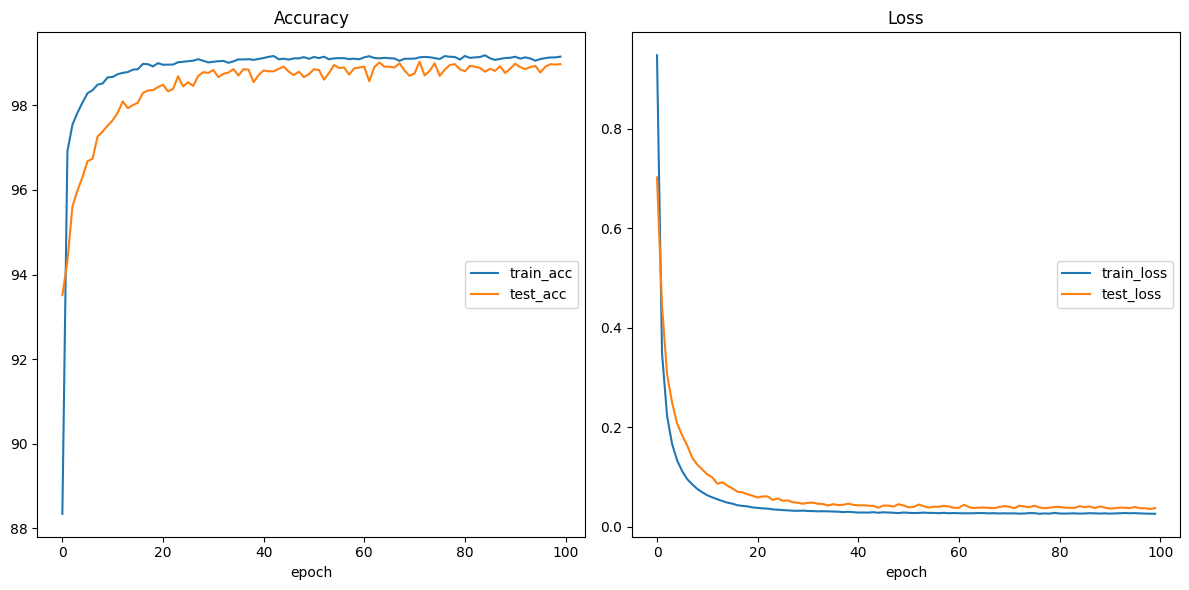

Accuracy
	train_acc        	 (min:   88.345, max:   99.182, cur:   99.150)
	test_acc         	 (min:   93.513, max:   99.031, cur:   98.972)
Loss
	train_loss       	 (min:    0.026, max:    0.948, cur:    0.026)
	test_loss        	 (min:    0.036, max:    0.702, cur:    0.038)
2023-02-01 18:49:52, Best Test Acc: 99.03, Time spent: 0:04:22


In [9]:
liveplot = PlotLosses(
    outputs=[MatplotlibPlot(cell_size=(6, 3)), 'ExtremaPrinter'],
    groups={
        'loss': ['train_loss', 'test_loss'],
        'acc': ['train_acc', 'test_acc']
    }
)

best_test_acc = 0
start_time = get_time()

for epoch in progress_bar(range(args.num_epochs)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, epoch)
    scheduler.step()

    test_loss, test_acc = evaluate(model, test_loader, criterion, f'Test Epoch: [{epoch}]')

    if best_test_acc < test_acc:
        best_test_acc = test_acc

    liveplot.update({
        'train_loss': train_loss,
        'test_loss': test_loss,
        'train_acc': train_acc,
        'test_acc': test_acc,
    })
    liveplot.send()

end_time = get_time()
timedelta = get_timedelta(start_time, end_time)
print(f'{end_time}, Best Test Acc: {best_test_acc:.2f}, Time spent: {timedelta}')

In [10]:
# mnist epoch[99] skewed[0.01] temperature[0.07] lambda[0.5]
# mode[0]: 41.89, 38.98, 98.62 -> instance
# mode[4]: 61.16, 39.58, 99.09 -> ours
# mode[5]: 58.36, 34.00, 98.90 -> all instance

# mnist epoch[99] skewed[0.01] temperature[0.10] lambda[0.5]
# mode[0]: 62.40, 31.63, 99.14 -> instance
# mode[4]: 57.58, 28.91, 99.01 -> ours
# mode[5]: 50.09, 19.74, 98.95 -> all instance

# mnist epoch[99] skewed[0.01] temperature[0.04] lambda[0.5]
# mode[0]: 59.23, 52.41, 98.61 -> instance
# mode[4]: 61.91, 49.31, 98.45 -> ours
# mode[5]: 71.60, 44.22, 99.13 -> all instance

# mnist epoch[99] skewed[0.01] temperature[0.01] lambda[0.5]
# mode[0]: 50.55, 49.03, 98.57 -> instance
# mode[4]: 59.19, 41.20, 98.71 -> ours
# mode[5]: 63.41, 39.52, 99.22 -> all instance

# mnist epoch[99] skewed[0.01] temperature[0.20] lambda[0.5]
# mode[0]: 42.10, 18.75, 99.12 -> instance
# mode[4]: 50.84, 21.69, 99.28 -> ours
# mode[5]: 44.95, 17.82, 98.80 -> all instance

In [11]:
# mnist epoch[99] skewed[0.01] temperature[0.07] lambda[0.5]
# mode[4]: 64.86, 47.85, 98.93 -> ours group[1] feat_dim[128]
# mode[4]: 65.20, 46.29, 98.88 -> ours group[2] feat_dim[128]
# mode[4]: 61.67, 36.61, 98.65 -> ours group[4] feat_dim[128]
# mode[4]: 55.24, 42.01, 98.83 -> ours group[8] feat_dim[128]
# mode[4]: 58.31, 37.44, 98.89 -> ours group[16] feat_dim[128]
# mode[4]: 53.06, 36.15, 98.65 -> ours group[32] feat_dim[128]
# mode[4]: 62.23, 40.36, 98.82 -> ours group[64] feat_dim[128]
# mode[4]: 50.00, 36.67, 98.63 -> ours group[128] feat_dim[128]

# mode[5]: 58.36, 34.00, 98.90 -> all instance feat_dim[128]
# mode[5]: 59.70, 36.49, 98.66 -> all instance feat_dim[64]
# mode[5]: 58.84, 34.10, 99.03 -> all instance feat_dim[256]

# mode[4]: 66.33, 42.72, 98.72 -> ours group[1] feat_dim[64]
# mode[4]: 64.13, 40.03, 98.69 -> ours group[2] feat_dim[64]
# mode[4]: 63.84, 34.45, 98.66 -> ours group[4] feat_dim[64]
# mode[4]: 60.40, 38.52, 99.02 -> ours group[8] feat_dim[64]
# mode[4]: 64.57, 37.90, 98.87 -> ours group[16] feat_dim[64]
# mode[4]: 56.65, 39.39, 98.63 -> ours group[32] feat_dim[64]
# mode[4]: 62.01, 36.68, 98.94 -> ours group[64] feat_dim[64]

In [12]:
# cifar epoch[99] skewed[0.01] temperature[0.07] lambda[0.5]
# mode[0]: 65.64, 62.02, 75.49 -> instance
# mode[5]: 68.26, 63.42, 75.13 -> all instance
# mode[4]: 65.43, 61.44, 73.38 -> ours group[1]
# mode[4]: 65.98, 61.44, 74.31 -> ours group[2]
# mode[4]: xxxxx, 61.96, xxxxx -> ours group[4]
# mode[4]: xxxxx, 61.43, xxxxx -> ours group[8]
# mode[4]: xxxxx, 61.37, xxxxx -> ours group[16]
# mode[4]: xxxxx, 61.42, xxxxx -> ours group[32]
# mode[4]: xxxxx, 61.48, xxxxx -> ours group[64]
# mode[4]: 65.56, 60.77, 73.85 -> ours group[128]
# mode[4]: xxxxx, 61.81, xxxxx -> ours group[256]

In [13]:
# mnist epoch[99] skewed[0.01] temperature[0.07] lambda[0.5]
# mode[0]: xxxxx, xxxxx, xxxxx -> instance
# mode[4]: xxxxx, xxxxx, xxxxx -> ours
# mode[5]: xxxxx, xxxxx, xxxxx -> all instance